# QA/QC
 
### What is QA/QC:
The task of annotating the quality of collected data/observation:

    - GOOD
    - BAD
    - SUSPECT
    - UNKNOWN
    
### Why QA/QC is needed:

Due to different conditions in the natural environment, observations collected by sensors may not be reliable.  
The quality assurance and control of data collected from sensor is very important to make sure the data usability.

### What are methods to annotate data with QA/QC flags:

[IOOS](https://ioos.github.io/ioos_qc/resources.html) has defined standard and statistical methods to annotate quality check on ocean time-series data. As for each essential ocean variable (EoV), different set of statistical tests are recommended to ensure the quality of collected data. Please read the [mannual](https://github.com/ioos/ioos_qc/blob/main/resources/argo-quality-control-manual.pdf) and [mannual In-situ](https://cdn.ioos.noaa.gov/media/2019/08/QARTOD_Currents_Update_Second_Final.pdf)


### Why thresholds are necessary

[IOOS](https://ioos.github.io/ioos_qc/resources.html) developed a IOOS_QC [QARTOD](https://ioos.github.io/ioos_qc/examples/Qartod_Single_Test_Example.html) python package in which different statistical functions are implemented. As each statistical function requires series to observations (time-series data), as well as it requires additional parameters which are referred as thresholds. 

For Example:

The most basic test (QARTOD function) for each EoV is `range test` where the natural range of value is used to validate the observation (data value). E.g., for sea surface temperature the global range is between -2.5 and 40.0. In this example, the lowest recorded temperature is -2.5 and the highest recorded temperature is 40.0. However, it is uncommon that temperature reaches to extreme that is why `range test` function also takes suspect threshold value to define which values can be suspect to error or warning. 

### What current datasets are avaiable with QA/QC annotations

In CIOOS Atlantic data repository, CMAR is the only partners whose dataset are annotated with QA/QC flags. Here is the list of dataset by CMAR:

1. Annapolis County
2. Antigonish County
3. Cape Breton County
4. Colchester County
5. Digby County
6. Inverness County
7. Lunenburg County
8. Pictou County
9. Queens County
10. Richmond County
11. Shelburne County
12. Victoria County
13. Yarmouth County

The description related to [CMAR QC Test & Threshold](https://dempsey-cmar.github.io/cmp-data-governance/pages/qc_tests.html#fn1) are provided. The EoVs annotated in these datasets are:

- dissolved oxygen
- sea surface temperature
- salinity
- depth check


### What we are trying to estimate

With the help of domain expert, CMAR has defined [thresholds](res/2024-10-24_cmar_water_quality_thresholds.csv) for each EoVs with respect to QARTOD function and month. Our objective is to learn the thresholds from existing data to annotate QA/QC flags. Estimating and learning threshold from known data will help us to predict QA/QC flags for unknown data which is not annotated.  

In this empirical study, we are focusing on `sea surface temperature`.

## Step#1:  Download the data as csv
The csv file contain first column as field name and second column contains the unit of each value.

## Step#2: Replacing String flag into int Flags
By default, the raw data contains flag in String but for easy to process we replace string into integer to optimize. We save the a new file as .csv

In [7]:
class QartodFlags:
    """Primary flags for QARTOD."""
    GOOD = 1
    UNKNOWN = 2
    SUSPECT = 3
    FAIL = 4
    MISSING = 9

In [ ]:
import os.path

import pandas as pd
import math

# TARGET EoV is SEA SURFACE TEMPERATURE
eov_range = (-2.0, 40)
eov_col_name = 'temperature'
eov_flag_name = 'qc_flag_temperature'
window_hour = 12
min_rows_in_a_chunk = 6
minimum_rows_for_each_group = 50


################# REPLACE FLAGS FROM STRING TO INT FROM CSV##################
def custom_replacement(value):
    if value == 'Not Evaluated':
        return QartodFlags.UNKNOWN
    elif value == 'Pass':
        return QartodFlags.GOOD
    elif value == 'Suspect/Of Interest':
        return QartodFlags.SUSPECT
    elif value == 'Fail':
        return QartodFlags.FAIL
    elif math.isnan(float(value)):
        return -1
    else:
        print(f"Unknown [{value}]")

    return value

csv_name = "D://CIOOS-Full-Data/Annapolis County Water Quality Data.csv"
# if the file is big then process into chunks
df_chunks = pd.read_csv(csv_name, chunksize=10000)
columns_ = None
header_written = False
for df in df_chunks:
    if columns_ is None:
        lst_col  = list(df.columns)
        # columns which starts with `qc_` are flag columns
        columns_ = [col for col in lst_col if "qc" in col.lower()]
    for col in columns_:
        df[col] = df[col].apply(custom_replacement)

    df.to_csv(csv_name.replace(".csv", "_FlagCode.csv") , index=False, mode='a', header= not header_written)
    header_written = True

# output: Annapolis County Water Quality Data_FlagCode.csv
#######################################################

## Step#3: Grouping the data
The data is collected on different stations. And each station may have installed one or more sensors. Thus we need to group data by station and sensor. 

In this code below, the csv `dataframe` is grouped on `station` and `sensor`. Within the data collected, we also need to validate if the collected data is from the same geographical area. That is the reason we group the location with difference of `eps=0.001`.  

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN

def group_with_dbscan(values, eps=0.001): 
    # Convert to 2D array as required by DBSCAN
    X = np.array(values).reshape(-1, 1)
    db = DBSCAN(eps=eps, min_samples=1)
    labels = db.fit_predict(X)
    # Group values by cluster label
    groups = []
    for label in sorted(set(labels)):
        group = [v for v, l in zip(values, labels) if l == label]
        groups.append(group)
    return groups


csv_name = "D://CIOOS-Full-Data/Annapolis County Water Quality Data_FlagCode.csv"
# lets make subdirectory
dir__ = os.path.dirname(csv_name) # D://CIOOS-Full-Data/
filename_ = os.path.basename(csv_name) #Annapolis County Water Quality Data_FlagCode.csv
new_directory_name = filename_.split(" ")[0]  #Annapolis
save_dir_ = os.path.join(dir__, new_directory_name)
os.makedirs(save_dir_) # D://CIOOS-Full-Data/Annapolis/
save_name =  os.path.join( save_dir_, filename_.replace("_FlagCode.csv","")) 


df_ = pd.read_csv(csv_name, parse_dates=['time'], skiprows=[1])
df_['latitude'] = df_['latitude'].astype(np.float32).round(4)
df_['longitude'] = df_['longitude'].astype(np.float32).round(4)

groups_ = df_.groupby(by=['station', 'sensor_serial_number'])
id_ = 1
for grp_, chunk in groups_:
    if chunk.shape[0] < minimum_rows_for_each_group: 
        continue
    # check if the data of more than 1 day is collected
    d_threshold = (pd.to_datetime(chunk['time'].max()) - pd.to_datetime(chunk['time'].min())).days > 1
    if not d_threshold:
        continue

    # checking if the data from same sensor is collected from different geographical area
    lat_uni_ = chunk['latitude'].unique()
    lon_uni_ = chunk['longitude'].unique()
    a_ = lat_uni_.std()
    b_ = lon_uni_.std()
    if a_ > 0.001:
        rows__ = chunk.shape[0]
        total_rows__ = 0
        lat_groups_ = group_with_dbscan(values=lat_uni_)
        for j, lat_grp in enumerate(lat_groups_):
            sub_chunk_ = chunk[ (chunk['latitude'] >= min(lat_grp)) &  (chunk['latitude'] <= max(lat_grp)) ]
            sub_b_ = sub_chunk_['longitude'].astype(np.float32).unique()
            assert sub_b_.std() <= 0.001, f"many longitudes {lat_uni_}"
            sub_chunk_.to_csv(save_name + f"-{id_}-{j}.csv", index=False)
            total_rows__ += sub_chunk_.shape[0]
            print(save_name + f"-{id_}-{j}.csv")
        assert total_rows__ == rows__, f"LAT sub chunk rows not equal to main chunk [{lat_groups_}] - [{lat_uni_}]"

    else:
        if b_ > 0.001:
            rows__ = chunk.shape[0]
            total_rows__ = 0
            lon_groups_ = group_with_dbscan(values=lon_uni_)
            for j, lon_grp in enumerate(lon_groups_):
                sub_chunk_ = chunk[(chunk['longitude'] >= min(lon_grp)) & (chunk['longitude'] <= max(lon_grp))]
                sub_chunk_.to_csv(save_name + f"-{id_}-{j}.csv", index=False)
                print(save_name + f"-{id_}-{j}.csv")
                total_rows__ += sub_chunk_.shape[0]

            assert total_rows__ == rows__, f"LON sub chunk rows not equal to main chunk [{lon_groups_}] - [{lon_groups_}]"
        else:
            chunk.to_csv(save_name+f"-{id_}.csv", index=False)
    id_+=1

## Step#4: Preparing data for Machine learning model



![Time-window](res/final_report_diagram.jpg)

## Current Feature Set:
1)	Rolling Standard Deviation
2)	Past-window mean – current value
3)	Future-window mean – current value
4)	Future-window mean – Past-window mean
5)	current value – ( (lead value – lag value)  / 2)
6)	Month Average Hourly Change – (lag Value – current Value)
7)	Month Average Hourly Change – (lead Value – current Value)
8)	(Current Value – q_997) if current value > q_997 else 0
9)	(Current Value – q_003) if current value < q_003 else 0
10)	 (Current Value – fwq_997) if current value > fwq_997 else 0
11)	(Current Value – fwq_003) if current value > fwq_003 else 0
12)	Month (1 - 12)

- ### Rolling Standard Deviation:
The description of this function is provided [here](https://dempsey-cmar.github.io/cmp-data-governance/pages/qc_tests.html#fn1). It calculate the standard deviation of the full window (see figure above) and compare it with current value. 
   
- ### Month Average Hourly Change:
The change of value per hour is different from month to month. Therefore, we take hourly change of values within a month and calculates their average. *For this feature, we must have the data for whole month in advance. that is why this feature cannot be calculated on real-time data.*
 
- ### q_997


In [ ]:
from datetime import timedelta

def apply_rolling_sd_with_time_reset(
        df,
        time_col='time',
        value_col='value',
        group_col='group',
        time_gap_threshold_min=15,
        rolling_window_minutes=60
):
    """
    This is implementation of rolling standard deviation defined in [https://dempsey-cmar.github.io/cmp-data-governance/pages/qc_tests.html#fn1]
    :param df:  Dataframe 
    :param time_col: <str> column name of time
    :param value_col: <str> column name of value
    :param group_col: <str> column name of group
    :param time_gap_threshold_min: <int> time gap threshold between two points
    :param rolling_window_minutes: <int>
    :return: updated dataframe
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    min_wind = int(rolling_window_minutes / time_gap_threshold_min)
    # Sort by group and time
    df.sort_values([time_col], inplace=True)

    results = []

    # Process each group separately
    for _, group_df in df.groupby(group_col):
        group_df = group_df.copy()

        # Calculate time difference in minutes
        group_df['time_diff_min'] = group_df[time_col].diff().dt.total_seconds() / 60

        # Start a new "segment" whenever time gap is too big
        group_df['segment'] = (group_df['time_diff_min'] > time_gap_threshold_min).cumsum()

        # Within each segment, apply rolling std
        def compute_rolling(g):
            g = g.set_index(time_col).sort_index()
            rolling_window = f'{rolling_window_minutes}min'
            g[f'{value_col}_rolling_sd'] = (
                g[value_col]
                .rolling(rolling_window, center=True, min_periods=min_wind)
                .std()
            )
            g = g.reset_index()
            start_ = g.iloc[0][time_col]
            for j in range(1, len(g[time_col])):
                prev_point_ = g.iloc[j][time_col]
                mints = (prev_point_ - start_).seconds / 60
                if not (mints < (rolling_window_minutes/2)):
                    g.loc[0:j-1 , f'{value_col}_rolling_sd'] = np.nan
                    break
            start_ = g.iloc[-1][time_col]
            for j in range(len(g[time_col])-1, 0, -1):
                prev_point_ = g.iloc[j][time_col]
                mints = (start_ - prev_point_).seconds / 60
                if not (mints < (rolling_window_minutes / 2)):
                    g.loc[j+1: , f'{value_col}_rolling_sd'] = np.nan
                    break
            return g

        rolled = group_df.groupby('segment', group_keys=False).apply(compute_rolling, include_groups=False)
        results.append(rolled)

    # Combine all grouped results
    final_df = pd.concat(results, ignore_index=True).drop(columns=['time_diff_min'])
    return final_df

def generate_time_windows(df, time_col='time', window_hours=2, min_rows_in_chunk=10, filter_flag = None, filter_flag_col = None):
    """
    Rolling over dataframe, generating defined slices based on time-window with step-size = 1
    :param df: Dataframe
    :param time_col:   Timestamp column name
    :param window_hours:  window size in hours
    :param min_rows_in_chunk:  minimum rows in a chunk/slice/sequence
    :return: list of Tuple( current row, past_time-window-dataframe, previous_time-window-dataframe)
    """
    df = df.dropna(axis=0).sort_values(by=time_col).reset_index(drop=True)
    df['time_diff_sec'] = df['time'].diff().dt.total_seconds()
    time_delta = timedelta(hours=window_hours, minutes=10)
    windowed_samples = []
    minimum_seconds_ = window_hours * 60* 59

    for i in range(1, len(df)):
        current_row = df.iloc[i]
        if (filter_flag is not None) and (filter_flag_col is not None):
            if current_row[filter_flag_col] != filter_flag:
                continue

        # OPTIMIZED ###########
        future_stop_, past_start_ = i + 1, i
        time_sum_past, time_sum_ = 0, 0
        past_stop, future_stop = False, False
        past_not_satisfied, future_not_satisfied = False, False
        while True:
            if not (time_sum_ > minimum_seconds_):
                if future_stop_ >= len(df):
                    future_not_satisfied = True
                else:
                    next_row = df.iloc[future_stop_]
                    next_row_time_diff = next_row['time_diff_sec']
                    time_sum_ = time_sum_ + next_row_time_diff
                    future_stop_ += 1
            else:
                future_stop = True

            if not (time_sum_past > minimum_seconds_):
                if past_start_ < 0:
                    past_not_satisfied = True
                else:
                    prev_row_time_diff = current_row['time_diff_sec']
                    time_sum_past = time_sum_past + prev_row_time_diff
                    past_start_ -= 1
            else:
                past_stop = True

            if future_not_satisfied or past_not_satisfied:
                break
            if future_stop and past_stop:
                break

        if (not past_not_satisfied) and (not future_not_satisfied):
            past_slot_df = df.iloc[past_start_:i]
            future_slot_df = df.iloc[i + 1: future_stop_]
            if (len(past_slot_df) >= min_rows_in_chunk) and ( len(future_slot_df) >= min_rows_in_chunk):
                tpl_ = (current_row, past_slot_df.drop_duplicates().reset_index(drop=True),
                        future_slot_df.drop_duplicates().reset_index(drop=True))
                windowed_samples.append(tpl_)

    return windowed_samples


def get_xy_from_dataframe(df,eov_flag_name,eov_col_name, window_hours, min_rows_in_chunk=6, ignore_labels = [QartodFlags.UNKNOWN, -1], dataset_name_string = None):
    """
    applying different function in dataframe 
    :param df: dataframe
    :param eov_flag_name: <str> column name wrt to flag_name 
    :param eov_col_name: <str>
    :param window_hours: 
    :param min_rows_in_chunk: 
    :param ignore_labels: ignoring these labels for data preparation
    :param dataset_name_string: used for print statement 
    :return: Numpy array 
    """
    dt_ = df['time'].dt
    df['yr'] = dt_.year
    df['mon'] = dt_.month
    year_month_stats_map = {}  # (year, month) stats
    group_by = df.groupby(by=['yr', 'mon'])
    for grp, chunk in group_by:
        values_ = chunk[eov_col_name]
        q_997 = values_.quantile(0.997)
        q_003 = values_.quantile(0.003)
        q_mean = values_.mean()
        q_std = values_.std()
        new_chunk = chunk.copy()
        new_chunk = new_chunk.set_index('time')
        df_hourly = new_chunk[eov_col_name].resample('1h').mean()
        avg_hourly_change = abs(df_hourly.diff()).mean()
        year_month_stats_map[grp] = (q_997, q_003, q_mean, q_std, avg_hourly_change)
    df['group'] = 1
    df = apply_rolling_sd_with_time_reset(
        df,
        time_col='time',
        value_col=eov_col_name,
        group_col='group',
        time_gap_threshold_min=2 * 60,
        rolling_window_minutes= 2 * window_hours * 60
    )
    df.drop(columns=['group'], inplace=True)
    lst_of_seq_ = generate_time_windows(df, window_hours=window_hours, min_rows_in_chunk=min_rows_in_chunk)
    # Feature engineering from window
    X, y = [], []
    for current_, past_, future_ in lst_of_seq_:
        label = current_[eov_flag_name]
        current_value = current_[eov_col_name]
        current_rolling = current_[eov_col_name+"_rolling_sd"]

        if label in ignore_labels:
            continue
        past_window = past_[eov_col_name]
        future_window = future_[eov_col_name]
        if label == QartodFlags.GOOD: #ignoring bad samples in past
            Y = past_[eov_flag_name]
            mask = ~((Y == QartodFlags.SUSPECT) | (Y == QartodFlags.FAIL))
            past_window = past_window[mask]


        if (past_window.shape[0] < min_rows_in_chunk) or (future_window.shape[0] < min_rows_in_chunk):
            continue


        # past_curent_window = pd.concat([past_window, pd.Series([current_value])])
        # future_cuurent_window = pd.concat([pd.Series([current_value]), future_window])
        full_window = pd.concat([past_window, pd.Series([current_value]), future_window])

        q_997, q_003, q_mean, q_std, avg_hourly_change = year_month_stats_map[
            (current_['time'].year, current_['time'].month)]
        q_997 = abs(current_value - q_997) if current_value > q_997 else 0
        q_003 = abs(q_003 - current_value) if current_value < q_003 else 0

        fwq_997 = full_window.quantile(0.997)
        fwq_003 = full_window.quantile(0.003)
        fwq_997 = abs(current_value - fwq_997) if current_value > fwq_997 else 0
        fwq_003 = abs(fwq_003 - current_value) if current_value < fwq_003 else 0

        # if label == QartodFlags.SUSPECT:
        #     a = 10
        spike_ref_ = ((past_window.tail(1).values[0] + future_window.head(1).values[0])/2)

        month_feature = np.eye(12, dtype=int)[current_['time'].month - 1]
        month_feature[current_['time'].month - 1] = 1
        past_mean = past_window.mean()
        future_mean = future_window.mean()
        features = np.array([
            current_rolling,
            abs(past_mean - current_value),
            abs(future_mean - current_value),
            abs(future_mean - past_mean),
            abs( current_value - spike_ref_ ),
            abs(avg_hourly_change - abs(past_window.tail(1).values[0] - current_value)),
            abs(avg_hourly_change - abs(future_window.head(1).values[0] - current_value)),
            q_997,
            q_003,
            fwq_997,
            fwq_003,
            *month_feature,
            label
        ])

        # if np.sum(np.isnan(np.array(features))) > 0:
        #     a =10
        X.append(features)

    X = np.vstack(X)
    X = np.round(X, 3)
    mask = X[:, -1] == QartodFlags.SUSPECT
    suspect_row = X[mask]
    mask_f = X[:, -1] == QartodFlags.FAIL
    fail_rows = X[mask_f]
    mask_g = X[:, -1] == QartodFlags.GOOD
    good_rows = X[mask_g]
    unique_unique_rows = np.unique(good_rows, axis=0)
    print(f"[{dataset_name_string}] \n Unique Extraction:  {good_rows.shape}  :-> {unique_unique_rows.shape}  + {fail_rows.shape} + {suspect_row.shape}")
    X = np.concatenate([suspect_row, good_rows, fail_rows])
    X = X.astype(np.float32)
    X = np.round(X, 3)
    return X


def get_file_names(dir__):
    """
    :param dir__: <str> directory path
    :return: list of file names
    """
    file_names = []
    for root_, dr_, files in os.walk(dir__):
        for fl in files:
            if fl.lower().endswith(".csv"):
                file_names.append(os.path.join(root_, fl))
    return file_names

def controlled_undersample(X, majority_class=QartodFlags.GOOD, reference_class=QartodFlags.SUSPECT, ratio=10):
    mask_majority = X[:, -1] == majority_class
    mask_reference = X[:, -1] == reference_class
    mask_other = X[:, -1] != majority_class

    # Subsets
    X_majority = X[mask_majority]
    X_other = X[mask_other]

    # Reference count from class 3
    n_reference = np.sum(mask_reference)
    n_majority_desired = min(len(X_majority), ratio * n_reference)

    # Sample from majority class
    indices = np.random.choice(len(X_majority), size=n_majority_desired, replace=False)
    X_majority_sampled = X_majority[indices]

    # Combine
    X_final = np.concatenate([X_other, X_majority_sampled], axis=0)
    print(f"ALL / Controlled Sampling : {X.shape} --> {X_final.shape}")
    return X_final

def parl_func(file_name):
    print(f"Processing : [{file_name}]")
    df = pd.read_csv(file_name, usecols=['time', eov_flag_name, eov_col_name])
    df.dropna(inplace=True, axis=0)
    if df.shape[0] < (min_rows_in_a_chunk*2):
        return None

    df['time'] = pd.to_datetime(df['time'])

    # Feature engineering from window
    X1= get_xy_from_dataframe(df, window_hours=window_hour, min_rows_in_chunk=min_rows_in_a_chunk, eov_col_name=eov_col_name,
                                   eov_flag_name=eov_flag_name , dataset_name_string=file_name)
    if np.sum(np.isnan(X1)) > 0:
        print(f" ---> DATASET WITH NAN: {file_name}")

    return X1

def remove_duplicates_from_nparray(nparr_, target_flag):
    """
    last column is the label/flag column in nparr_
    :param nparr_: numpy array
    :param flag:
    :return: numpy array
    """
    mask_g = nparr_[:, -1] == target_flag
    good_rows = nparr_[mask_g]
    mask = nparr_[:, -1] != target_flag
    other_rows_ = nparr_[mask]

    unique_unique_rows = np.unique(good_rows, axis=0)
    X = np.concatenate([unique_unique_rows, other_rows_])
    return X

In [ ]:
import pickle
from tqdm import tqdm


chunk_dir = "D://CIOOS-Full-Data/"
datasets__ = [ "Annapolis"]

for dataset_ in datasets__:
    file_names = get_file_names(os.path.join(chunk_dir, dataset_))  
    x_np_array_file = os.path.join(chunk_dir, dataset_, f"{dataset_}-X_np_array.pkl")
    if os.path.exists(x_np_array_file):
        print(f"-- Skipping  - [{dataset_}] because NPARRAY file exist")
        continue
    print(f"-- Looking Into - [{dataset_}]")


    F_A = None
    for fname in tqdm(file_names):   # Uncomment for SEQUETIAL EXECUTION
        X1 = parl_func(fname)       # Uncomment for SEQUETIAL EXECUTION
    # lst_of_xy = p_umap(parl_func, file_names)   # Uncomment for PARALLEL EXECUTION
    # for X1 in lst_of_xy:                        # Uncomment for PARALLEL EXECUTION
        if X1 is None:
            continue
        if F_A is None:
            F_A = X1
        else:
            F_A = np.concatenate((F_A, X1), axis=0)

    X = controlled_undersample(F_A, majority_class=QartodFlags.GOOD, reference_class=QartodFlags.SUSPECT, ratio=10)
    t_ = F_A.shape
    F_A = remove_duplicates_from_nparray(F_A, QartodFlags.GOOD)

    X_ = F_A[:, :-1]
    Y_ = F_A[:, -1]
    print(f"{t_}  --->  {F_A.shape} ->   {Y_.shape}  ,  {X_.shape}   ===>  .PKL ")

    pickle.dump(X_, open(x_np_array_file, 'wb'))
    pickle.dump(Y_, open(os.path.join(chunk_dir, dataset_,f"{dataset_}-Y_np_array.pkl"), 'wb'))

# Step#4: Model Training - Applying Random Forest to classify data

GOOD: (1379543, 24)
GOOD After resample: (229360, 24)
(252296, 23)
(252296,)
(252296, 23)
(252296,)
Validation Confusion Matrix:
[[22750   184     2]
 [  505  1219    27]
 [    0    26   517]]

Classification Report:
              precision    recall  f1-score   support

         1.0     0.9783    0.9919    0.9850     22936
         3.0     0.8530    0.6962    0.7667      1751
         4.0     0.9469    0.9521    0.9495       543

    accuracy                         0.9705     25230
   macro avg     0.9261    0.8801    0.9004     25230
weighted avg     0.9689    0.9705    0.9691     25230

Accuracy: 0.9705112960760999


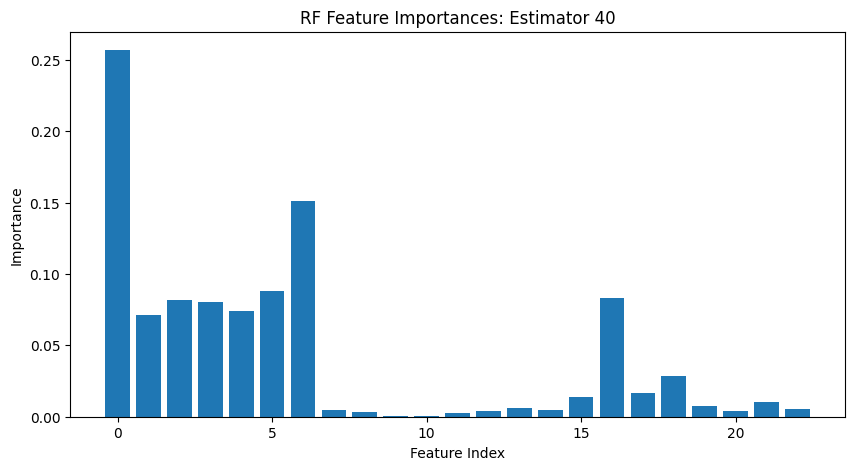

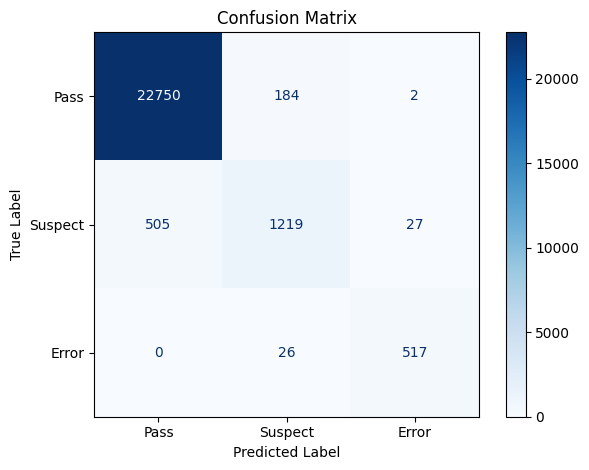

[[267777   2837      0]
 [   861    985    100]
 [     0     14      8]]
              precision    recall  f1-score   support

         1.0     0.9968    0.9895    0.9931    270614
         3.0     0.2568    0.5062    0.3407      1946
         4.0     0.0741    0.3636    0.1231        22

    accuracy                         0.9860    272582
   macro avg     0.4425    0.6198    0.4856    272582
weighted avg     0.9914    0.9860    0.9884    272582

Accuracy: 0.9860152174391559


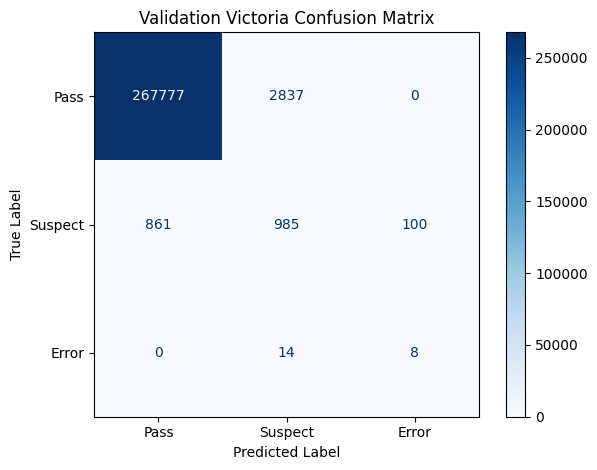

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
chunk_dir = "D://CIOOS-Full-Data/chunking/"
# Optional: Feature importances
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os, pickle
import numpy as np

Xs = [
    'Annapolis/Annapolis-X_np_array.pkl',
      'Antigonish/Antigonish-X_np_array.pkl',
      # 'Inverness-X_np_array.pkl',
      # 'Queens-X_np_array.pkl',
    'Cape/Cape-X_np_array.pkl',
    'Victoria/Victoria-X_np_array.pkl',
     # 'Colchester/Colchester-X_np_array.pkl',
     #      'Digby/Digby-X_np_array.pkl',
]
Ys = [
    'Annapolis/Annapolis-Y_np_array.pkl',
      'Antigonish/Antigonish-Y_np_array.pkl',
      # 'Inverness-Y_np_array.pkl',
      # 'Queens-Y_np_array.pkl',
    'Cape/Cape-Y_np_array.pkl',
      'Victoria/Victoria-Y_np_array.pkl',
      # 'Colchester/Colchester-Y_np_array.pkl',
      # 'Digby/Digby-Y_np_array.pkl',

]
label_mapping = {
    1: "Pass",
    3: "Suspect",
    4: "Error",
    9: "Missing"
}
lst_X = []
lst_Y = []
for ei in range(len(Xs)):
    Xpath = os.path.join(chunk_dir , Xs[ei])
    yPath = os.path.join(chunk_dir, Ys[ei])
    X1 = pickle.load(open(Xpath, 'rb'))
    y1 = pickle.load(open(yPath, 'rb'))
    lst_X.append(X1)
    lst_Y.append(y1)


X = np.concatenate(tuple(lst_X[0:-1]), axis=0)
y = np.concatenate(tuple(lst_Y[0:-1]), axis=0)

valid_X, valid_Y = lst_X[-1], lst_Y[-1]

data_ = np.concatenate((X, y.reshape(-1, 1)), axis=1)


mask_g = data_[:, -1] == QartodFlags.GOOD  # PASS samples
good_rows = data_[mask_g]  # filtering PASS Flag rows
mask_o = data_[:, -1] != QartodFlags.GOOD
other_rows_ = data_[mask_o]  # filter not PASS Flag rows

num_rows_to_select = other_rows_.shape[0] * 10

unique_unique_rows = np.unique(good_rows, axis=0)  # getting unique rows from PASS Flags
print(f"GOOD: {unique_unique_rows.shape}")
random_row_indices = np.random.choice(unique_unique_rows.shape[0], size=num_rows_to_select, replace=False)

# Extract the random rows
unique_unique_rows = unique_unique_rows[random_row_indices, :]
print(f"GOOD After resample: {unique_unique_rows.shape}")

data_ = np.concatenate((unique_unique_rows, other_rows_), axis=0)
np.random.shuffle(data_)
X = data_[:, :-1]
y = data_[:, -1]

X = np.nan_to_num(X, nan=0.0)

print(X.shape)
print(y.shape)

# scaler_x = MinMaxScaler()
# scaler_x = scaler_x.fit(X)
# X = scaler_x.transform(X)

# valid_X = scaler_x.transform(valid_X)

X = np.round(X, 2)
valid_X = np.round(valid_X, 2)

print(X.shape)
print(y.shape)

# Step 1: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

n_estimatr = 40
# Step 2: Train Random Forest
rf = RandomForestClassifier(n_estimators=n_estimatr, random_state=7, class_weight='balanced')
rf.fit(X_train, y_train)

# Step 3: Predictions
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
# Step 4: Evaluation
print("Validation Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred))


importances = rf.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title(f"RF Feature Importances: Estimator {n_estimatr}")
plt.show()

class_names = [label_mapping[i] for i in sorted(np.unique(y_test))]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

valid_y_pred = rf.predict(valid_X)
cm = confusion_matrix(valid_Y, valid_y_pred)
print(cm)
print(classification_report(valid_Y, valid_y_pred, digits=4))
print("Accuracy:", accuracy_score(valid_Y, valid_y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Validation Victoria Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Step#4: Model Training -Multi-layer Perceptron Model 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

scaler_x = MinMaxScaler()
scaler_x = scaler_x.fit(X)
X = scaler_x.transform(X)

valid_X = scaler_x.transform(valid_X)

# Convert labels to one-hot encoding
y_cat = to_categorical(y)

print(y_cat.shape)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights_dict = dict(enumerate(class_weights))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.1, random_state=16)

# Feedforward neural network (MLP)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])
print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=30, batch_size=32,
          validation_data=(X_test, y_test),
          class_weight=class_weights_dict, verbose=2)

# Evaluate
y_pred_probs = model.predict(X_test, verbose=2)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, digits=4))


cm = confusion_matrix(y_true, y_pred)

print(cm)
# Optional: get class names if known (else use numbers)
class_names = [label_mapping[i] for i in sorted(np.unique(y_true))]

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("testing_cm.png")

valid_y_pred_probs = model.predict(valid_X, verbose=2)
valid_y_pred = np.argmax(valid_y_pred_probs, axis=1)
valid_y_true = valid_Y

print(classification_report(valid_y_true, valid_y_pred, digits=4))
cm_valid = confusion_matrix(valid_y_true, valid_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Validation Victoria Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("validation_cm.png")